<a href="https://colab.research.google.com/github/gabrielperao/upmcfood101-multimodal-classification/blob/main/multimodal_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho redes neurais - Classificação multimodal de imagem + texto
* João Vitor Tigre Almeida 12543311
* Gabriel Barbosa de Amorim Perão 12677874

# Descricao do problema
Esse notebook descreve um modelo de classificação multimodal que usa imagem e texto para classificar entradas em pratos de comida. Essa classificação pode ser usada para extrair informações de páginas da itnernet, que frequentemente apresentam uma imagem seguida de um breve texto relacionado. O dataset usado para tal foi baseado no UPMC Food101, disponivel no link:
https://www.kaggle.com/gianmarco96/upmcfood101 , porém fazendo uso de uma seleção reduzida de imagens para facilitar o treino e a correção.

Para explorar a abordagem multimodal, primeiro criamos um modelo que faz a classificação a partir apenas do texto, usando o encoder já pronto do BERT e uma camada completamente conectada. Em seguida adicionamos ao modelo camadas da rede convolucional ResNet, alterada para se adequar ao número de classes do problema. Ao compararar ambos foi notável que o segundo obteve mais precisão, isso é, o modelo foi capaz de usar as informações de ambas as fontes para melhorar sua classificação.

## Importando bibliotecas


In [ ]:
!pip install transformers timm

In [ ]:
import json
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import os

from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModel, AutoTokenizer, get_scheduler
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from tqdm.notebook import tqdm, trange
from time import perf_counter
from PIL import Image
from google.colab import drive

drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carregando dados

Esse código carrega o dataset de uma pasta nomeada 'results' do drive. Essa pasta deve conter duas pastas, no seguinte formato:
*    **texts** ->
 *   **train_titles.csv**, que contem tres colunas: o local da imagem, o texto descritivo, e a classificação correta para dados de treino.
 *   **test_titles.csv**, que é igual ao train_titles porem para dados de teste.
*    **images** ->
 *     **train** -> As imagens de treino, separadas por categoria, em formato .jpg.
 *     **test** -> Igual acima, porem para teste.


Para baixar o dataset, pode-se acessar o [link do kaggle](https://www.google.com/url?q=https%3A%2F%2Fwww.kaggle.com%2Fgianmarco96%2Fupmcfood101), o [link da versão reduzida que usamos](https://drive.google.com/file/d/16GdzFjMHf6DJVzCOKL0V7fgE-cu_V4yG/view?usp=drive_link) ou uma cópia da versão reduzida disponível no github.


In [ ]:
# Cria pasta para os resultados das classificacoes
RESULTS_FOLDER = '/content/redesneurais/results/'
os.makedirs(RESULTS_FOLDER, exist_ok=True)

In [ ]:
# Le os csvs. Re-define o caminho correto das imagens levando em conta
# o local da pasta images.
df_train = pd.read_csv('/content/drive/MyDrive/reduced/texts/train_titles.csv', names=['img_path', 'text', 'label'])
df_train['img_path'] = '/content/drive/MyDrive/reduced/images/train/' + df_train['label'] + '/' + df_train['img_path']
df_train = df_train.sample(256)

df_test = pd.read_csv('/content/drive/MyDrive/reduced/texts/test_titles.csv', names=['img_path', 'text', 'label'])
df_test['img_path'] = '/content/drive/MyDrive/reduced/images/test/' + df_test['label'] + '/' + df_test['img_path']
df_test = df_test.sample(256)

df_train

,img_path,text,label
1564,/content/drive/MyDrive/reduced/images/train/ba...,Classic Baklava Recipe | Brown Eyed Baker,baklava
1920,/content/drive/MyDrive/reduced/images/train/ba...,Traditional Greek Baklava Recipe with Walnuts ...,baklava
456,/content/drive/MyDrive/reduced/images/train/ap...,Essential Recipe: Double-Crust Apple Pie \xe...,apple_pie
644,/content/drive/MyDrive/reduced/images/train/ap...,Sour Cream Apple Pie Recipe | MyRecipes.com,apple_pie
3150,/content/drive/MyDrive/reduced/images/train/be...,Deals | Hot,beef_tartare
...,...,...,...
2804,/content/drive/MyDrive/reduced/images/train/be...,Mariage Freres | I love butter and sugar.,beef_tartare
2406,/content/drive/MyDrive/reduced/images/train/be...,Paleo Appetizers and Snacks Recipes,beef_carpaccio
927,/content/drive/MyDrive/reduced/images/train/ba...,"[[""Honey Mustard Baby Back Ribs Recipe &#150; ...",baby_back_ribs
1828,/content/drive/MyDrive/reduced/images/train/ba...,Apricot White Chocolate Baklava | Phyllo.com,baklava


Categoria: beef_carpaccio
Texto: How to Spread Florentine Fever


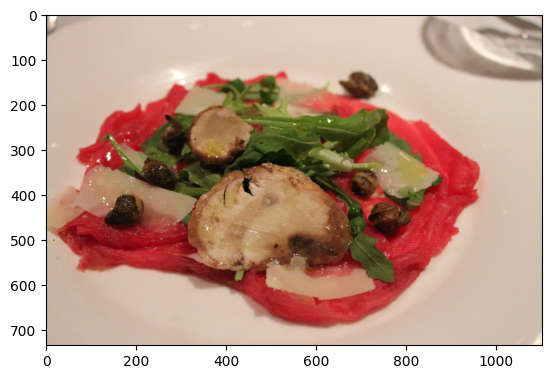

In [ ]:
# Plota um exemplo
exemplo = df_train.iloc[random.randint(0, df_train.shape[0])]

print('Categoria:', exemplo['label'])
print('Texto:', exemplo['text'])
im = Image.open(exemplo['img_path'])
plt.imshow(im)

In [ ]:
# Cria indices para cada categoria bem como mapas de conversao
label_to_id = {lab:i for i, lab in enumerate(df_train['label'].sort_values().unique())}
id_to_label = {v:k for k,v in label_to_id.items()}
num_out_labels = len(label_to_id)

label_to_id

{'apple_pie': 0,
 'baby_back_ribs': 1,
 'baklava': 2,
 'beef_carpaccio': 3,
 'beef_tartare': 4}

In [ ]:
# Define hyperparametros
num_train_epochs = 8
batch_size = 32
learning_rate = 1.0e-5
weight_decay = 0.01
warmup_steps = 0
max_seq_length = 64

## BERT

O primeiro modelo usa o BERT para fazer a classificação inteiramente baseada no texto.

### Dataset
Já que buscamos usar só o texto, criamos um dataset que recebe apenas o texto e o label (alvo da classificão.

In [ ]:
class TextDataset(Dataset):
    def __init__(self, df, label_to_id, text_field="text", label_field="label"):
        self.df = df.reset_index(drop=True)

        # Mapa de label para id numerico
        self.label_to_id = label_to_id

        # Campos para acesso ao dataset
        self.text_field = text_field
        self.label_field = label_field

    def __getitem__(self, index):

        # Retorna a label como id numerico
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]

        return text, label

    def __len__(self):
        return self.df.shape[0]

### Modelo
O modelo usa o BERT para o encoding e passa o encoding para uma camada totalmente conectada com 5 saídas (o número de resultados de classificação possíveis).

In [ ]:
class VLBertModel(nn.Module):

    def __init__(self, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()

        self.num_labels = num_labels

        # Usa um modelo pre treinado do BERT seguido de uma camada inteiramente
        # conectada para classificacao.
        self.text_encoder = AutoModel.from_pretrained(text_pretrained)
        self.classifier = nn.Linear(
            self.text_encoder.config.hidden_size, num_labels)

    def forward(self, text):
        output = self.text_encoder(text.input_ids, attention_mask=text.attention_mask, return_dict=True)
        logits = self.classifier(output.last_hidden_state[:, 0, :])
        return logits

bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = VLBertModel(num_labels=num_out_labels, text_pretrained='bert-base-uncased')
bert_model = bert_model.to(device)

### Treinamento
Treinamento padrao usando o pytorch.

In [ ]:
train_dataset = TextDataset(df=df_train, label_to_id=label_to_id, text_field='text', label_field='label')
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size,
                    sampler=train_sampler)

t_total = len(train_dataloader) * num_train_epochs

# Usamos o AdamW para otimizacao
optimizer = AdamW(bert_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()

bert_model.train()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):
        b_text, b_labels = batch
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )

        b_labels = b_labels.to(device)
        b_inputs = b_inputs.to(device)

        bert_model.zero_grad()
        b_logits = bert_model(text=b_inputs)

        # Calculamos o erro e atualizamos os pesos por backpropagation
        loss = criterion(b_logits, b_labels)
        epoch_total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_loss = epoch_total_loss/len(train_dataloader)
    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])

print('Treino completo')

Epochs:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/8 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 12.626949191093445
    avg_epoch_loss = 1.5783686488866806
    learning rate = 9.619397662556434e-06


Batch:   0%|          | 0/8 [00:00<?, ?it/s]

epoch = 1
    epoch_loss = 11.457875609397888
    avg_epoch_loss = 1.432234451174736
    learning rate = 8.535533905932739e-06


Batch:   0%|          | 0/8 [00:00<?, ?it/s]

epoch = 2
    epoch_loss = 9.91357707977295
    avg_epoch_loss = 1.2391971349716187
    learning rate = 6.913417161825449e-06


Batch:   0%|          | 0/8 [00:00<?, ?it/s]

epoch = 3
    epoch_loss = 8.373687446117401
    avg_epoch_loss = 1.0467109307646751
    learning rate = 5e-06


Batch:   0%|          | 0/8 [00:00<?, ?it/s]

epoch = 4
    epoch_loss = 7.136401116847992
    avg_epoch_loss = 0.892050139605999
    learning rate = 3.0865828381745515e-06


Batch:   0%|          | 0/8 [00:00<?, ?it/s]

epoch = 5
    epoch_loss = 6.420909762382507
    avg_epoch_loss = 0.8026137202978134
    learning rate = 1.4644660940672628e-06


Batch:   0%|          | 0/8 [00:00<?, ?it/s]

epoch = 6
    epoch_loss = 5.855347275733948
    avg_epoch_loss = 0.7319184094667435
    learning rate = 3.8060233744356634e-07


Batch:   0%|          | 0/8 [00:00<?, ?it/s]

epoch = 7
    epoch_loss = 5.815420627593994
    avg_epoch_loss = 0.7269275784492493
    learning rate = 0.0
Treino completo


### Teste

In [ ]:
bert_prediction_results = []

test_dataset = TextDataset(df=df_test, label_to_id=label_to_id, text_field='text', label_field='label')
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            sampler=test_sampler)


for batch in tqdm(test_dataloader):
  bert_model.eval()

  b_text, b_labels = batch
  b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)
  b_labels = b_labels.to(device)
  b_inputs = b_inputs.to(device)

  with torch.no_grad():
      b_logits = bert_model(text=b_inputs)
      b_logits = b_logits.detach().cpu()

  bert_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

bert_prediction_labels = [id_to_label[p] for p in bert_prediction_results]
bert_class_report = classification_report(df_test['label'], bert_prediction_labels, output_dict=True)

with open(RESULTS_FOLDER + 'bert_class_report.json', 'w') as f:
  json.dump(bert_class_report, f)

print(bert_class_report['accuracy'])

  0%|          | 0/8 [00:00<?, ?it/s]

0.75390625


## BERT + ResNet-50
O segundo modelo usa o BERT bem como o ResNet-50 para processar tanto o texto quanto as imagens. Ele treina ambos e adiciona uma camada completamente conectada ao fim com 5 classes para classificação.

### Dataset
Nesse caso o dataset terá que incluir tanto o texto como as imagens. As imagens tem que ser transformadas para ser estarem no formato esperado pelo ResNet.

In [ ]:
class ResNetDataset(Dataset):
    def __init__(self, df, label_to_id, train=False, text_field="text", label_field="label", image_path_field="img_path"):
        self.df = df.reset_index(drop=True)
        self.label_to_id = label_to_id
        self.train = train

        # Cmapos de acesso ao dataset
        self.text_field = text_field
        self.label_field = label_field
        self.image_path_field = image_path_field

        # ResNet-50 settings
        self.img_size = 224
        self.mean, self.std = (
            0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)

        # Funcoes para deixar a imagem no formato esperado pelo ResNet,
        # com aleatoriedade para treino para evitar overfitting
        self.train_transform_func = transforms.Compose(
                [transforms.RandomResizedCrop(self.img_size, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])

        self.eval_transform_func = transforms.Compose(
                [transforms.Resize(256),
                    transforms.CenterCrop(self.img_size),
                    transforms.ToTensor(),
                    transforms.Normalize(self.mean, self.std)
                    ])

    def __getitem__(self, index):
        text = str(self.df.at[index, self.text_field])
        label = self.label_to_id[self.df.at[index, self.label_field]]
        img_path = self.df.at[index, self.image_path_field]

        image = Image.open(img_path)
        if self.train:
          img = self.train_transform_func(image)
        else:
          img = self.eval_transform_func(image)

        return text, label, img

    def __len__(self):
        return self.df.shape[0]

### Modelo
O modelo ResNet possui uma camada inteiramente conectada com 1000 classes possiveis no seu fim. Como no caso não temos 1000 classes, removemos esssa camada recriando o modelo sem ela.
Em seguida, combinamos esse modelo com o do BERT e adicionamos uma camada inteiramente conectada em seguida com o numero de classes que usamos (5).


In [ ]:
from torchvision.models.resnet import resnet50

class ResNetFeatureModel(nn.Module):
    def __init__(self, output_layer):
        super().__init__()
        self.output_layer = output_layer
        pretrained_resnet = resnet50(pretrained=True)
        self.children_list = []

        # Adiciona todas as camadas exceto a ultima, pois o ResNet classifica
        # imagens em 1000 classes, o que nao e o caso
        for n,c in pretrained_resnet.named_children():
            self.children_list.append(c)
            if n == self.output_layer:
                break

        self.net = nn.Sequential(*self.children_list)


    def forward(self,x):
        x = self.net(x)
        x = torch.flatten(x, 1)
        return x

class BertResNetModel(nn.Module):
  def __init__(self, num_labels, text_pretrained='bert-base-uncased'):
      super().__init__()

      # Usa o BERT e o modelo baseado no ResNet para criar uma rede multimodal
      self.text_encoder = AutoModel.from_pretrained(text_pretrained)
      self.visual_encoder = ResNetFeatureModel(output_layer='avgpool')
      self.image_hidden_size = 2048

      # Adiciona uma camada completamente conectada com o numero de categorias usado no caso (5)
      self.classifier = nn.Linear(self.text_encoder.config.hidden_size + self.image_hidden_size, num_labels)

  def forward(self, text, image):
      text_output = self.text_encoder(**text)
      text_feature = text_output.last_hidden_state[:, 0, :]
      img_feature = self.visual_encoder(image)
      features = torch.cat((text_feature, img_feature), 1)

      logits = self.classifier(features)

      return logits

bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
resnet_model = BertResNetModel(num_labels=num_out_labels, text_pretrained='bert-base-uncased')
resnet_model = resnet_model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Treinamento


In [ ]:
train_dataset = ResNetDataset(df=df_train, label_to_id=label_to_id, train=True, text_field='text', label_field='label', image_path_field='img_path')
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size,
                    sampler=train_sampler)


t_total = len(train_dataloader) * num_train_epochs

# Usamos AdamW para otimizacao
optimizer = AdamW(resnet_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

criterion = nn.CrossEntropyLoss()

resnet_model.train()
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):
        b_text, b_labels, b_imgs = batch
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
        )

        b_labels = b_labels.to(device)
        b_imgs = b_imgs.to(device)
        b_inputs = b_inputs.to(device)

        resnet_model.zero_grad()
        b_logits = resnet_model(text=b_inputs, image=b_imgs)

        # Calculamos o erro e atualizamos os pesos por backpropagation
        loss = criterion(b_logits, b_labels)
        epoch_total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])

print('Training completed')

Epochs:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/8 [00:00<?, ?it/s]

epoch = 0
    epoch_loss = 12.668728470802307
    avg_epoch_loss = 1.5835910588502884
    learning rate = 9.619397662556434e-06


Batch:   0%|          | 0/8 [00:00<?, ?it/s]

epoch = 1
    epoch_loss = 10.991782307624817
    avg_epoch_loss = 1.3739727884531021
    learning rate = 8.535533905932739e-06


Batch:   0%|          | 0/8 [00:00<?, ?it/s]

epoch = 2
    epoch_loss = 9.740633130073547
    avg_epoch_loss = 1.2175791412591934
    learning rate = 6.913417161825449e-06


Batch:   0%|          | 0/8 [00:00<?, ?it/s]

epoch = 3
    epoch_loss = 8.491557598114014
    avg_epoch_loss = 1.0614446997642517
    learning rate = 5e-06


Batch:   0%|          | 0/8 [00:00<?, ?it/s]

epoch = 4
    epoch_loss = 7.489753007888794
    avg_epoch_loss = 0.9362191259860992
    learning rate = 3.0865828381745515e-06


Batch:   0%|          | 0/8 [00:00<?, ?it/s]

epoch = 5
    epoch_loss = 6.844284236431122
    avg_epoch_loss = 0.8555355295538902
    learning rate = 1.4644660940672628e-06


Batch:   0%|          | 0/8 [00:00<?, ?it/s]

epoch = 6
    epoch_loss = 6.461389064788818
    avg_epoch_loss = 0.8076736330986023
    learning rate = 3.8060233744356634e-07


Batch:   0%|          | 0/8 [00:00<?, ?it/s]

epoch = 7
    epoch_loss = 6.330815374851227
    avg_epoch_loss = 0.7913519218564034
    learning rate = 0.0
Training completed


### Teste

In [ ]:
resnet_prediction_results = []

test_dataset = ResNetDataset(df=df_test, label_to_id=label_to_id, train=False, text_field='text', label_field='label', image_path_field='img_path')
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            sampler=test_sampler)


for batch in tqdm(test_dataloader):
  resnet_model.eval()

  b_text, b_labels, b_imgs = batch

  b_inputs = bert_tokenizer(list(b_text), truncation=True, max_length=max_seq_length, return_tensors="pt", padding=True)

  b_labels = b_labels.to(device)
  b_imgs = b_imgs.to(device)
  b_inputs = b_inputs.to(device)

  with torch.no_grad():
      b_logits = resnet_model(text=b_inputs, image=b_imgs)
      b_logits = b_logits.detach().cpu()

  resnet_prediction_results += torch.argmax(b_logits, dim=-1).tolist()

resnet_prediction_labels = [id_to_label[p] for p in resnet_prediction_results]

resnet_class_report = classification_report(df_test['label'], resnet_prediction_labels, output_dict=True)

with open(RESULTS_FOLDER + 'resnet_class_report.json', 'w') as f:
  json.dump(resnet_class_report, f)

print(resnet_class_report['accuracy'])

  0%|          | 0/8 [00:00<?, ?it/s]

0.7890625


# Próximos passos

Em seguida, tentamos aplicar o mesmo modelo para um dataset com imagens de raio-x e descrições clinicas (disponivel no hugging face: https://huggingface.co/datasets/itsanmolgupta/mimic-cxr-dataset) para deteção de pneumonia. Não conseugimos resultados viáveis pois encontramos dificuldades lidando com dados reais, tais como escassez de dados de qualidade. Além disso, o dataset mais acessível não tinha labels claras, tornando necessárias tecnicas de limpagem e manipulação de dados. Lidar com essa ambiguidade e aplicar o modelo para um caso real seria o próximo passo.